Per il riconoscimento facciale abbiamo bisogno di seguire i passi indicati nel paper firmato da Turk e Pentland:
- Aquisire un dataset di facce
- Calcolare le eigenfaces dal set di apprendimento.
- Aquisire e preparare la galleria. 
- La galleria sarà utilizzata per creare il mondo dalla quale il sistema riconoscerà i volti.
- Calcolare la distribuzione M dimensionale per ogni individuo proiettando la faccia sullo spazio delle facce.

Una volta inizializzato il sistema, possiamo procedere in questo modo:
- Calcolare un set di pesi in base all'immagine fornita e gli autovalori proiettando l'immagine su ogni eigenfaces 
- Determinare se l'immagine è effettivamente un volto controllando che sia abbastanza vicino allo spazio delle facce
- Calcolare i pesi in modo da definire il volto più vicino alle proiezioni disponibili nel mondo del classificatore


In [12]:
import os
import glob 
import numpy as np
import cv2
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import pickle
from sklearn.utils import shuffle

dim = 64

faces_xml = 'haarcascade_frontalface_alt.xml'
face_cascade = cv2.CascadeClassifier()
if not face_cascade.load(faces_xml):
    print('--(!)Errore durante il caricamento del file xml per le facce')
    exit(0)
    

np.random.seed(42)


Caricamento dei percorsi delle foto in un dizionario che verrà poi ciclato per caricare foto e label corrispondenti

In [13]:
root = "foto64x64"
cwd = os.getcwd()
listDir = os.listdir(root)
tagFoto = {}

for dir in listDir:
    imgs =  glob.glob(f"{root}/{dir}/*.jpg")
    tagFoto[dir] = imgs


La funzione normalize prende come parametro un array ndimensionale di numpy e lo normalizza con il metodo minMax, questa operazione ci permette di ottimizzare il processo di calcolo della PCA (si risparmia in media il 50% del tempo) e migliora le approssimazioni

In [14]:
def normalize(matrix):
    normalizedData = (matrix-np.min(matrix))/(np.max(matrix)-np.min(matrix))
    return normalizedData

La funzione violajones prende in input un percorso dalla quale caricare un immagine, in questa specifica implementazione ritorna solo l'ultima faccia letta, questo è un comportamento desiderato in quanto il nostro set di training delle autofacce presenta foto con un unico volto.
La funzione utilizzata per trovare le facce è la detectMultiScale dell'oggetto face_cascade, questa funzione riconosce le facce attraverso una serie di classificatori deboli, è possibile decidere quanti di questi bisogna far attivare per riconoscere effettivamente un volto, di default il parametro è impostato a 3.

I classificatori deboli sono implementati tramite delle matrici che scorrono nell'immagine per trovare i tratti distintivi dei volti, queste matrici sono descritte nel file *haarcascade_frontalface_alt.xlm* cosi come la dimensione del ridimensionamento che viene applicato ciclicamente per rendere i riconoscimenti indipendenti dalla dimensione dell'immagine iniziale, la velocità di ridimensionamento è modificabile tramite il parametro scaleFactor che prevede di ricevere un double che indichi di quanto scalare l'immagine ad ogni iterazione, il suo default è 1.1 che significa ridurre del 10% le dimensioni ad ogni iterazione (ovviamente più iterazioni si fanno fare al detector maggiore sarà la precisione cosi come maggiore sarà il tempo di elaborazione).

Due ulteriori parametri sono molto utili: minSize e maxSize che, attraverso la tupla che accettano in input, definiscono le dimensioni minime e massime per ricoscere un volto.

In [15]:
def violajones(im):
    img = cv2.imread(im,0)
    faceROI = np.zeros((dim,dim), dtype=np.float32)
    faces = face_cascade.detectMultiScale(img)
    for (x, y, w, h) in faces:
        faceROI = img[y:y + h, x:x + w]
        faceROI = cv2.resize(faceROI,(dim,dim), interpolation=cv2.INTER_LINEAR)
        #faceROI = preprocess(faceROI)
        
    return faceROI

Per ottenere il volto medio o caratteristiche comuni di tutti i volti caricati, possiamo sommare tutte le facce che il metodo violajones ritorna per poi dividerle per il numero di volti trovati, otterremo quindi un immagine che ricorda un volto ma che di fatto non ha caratteristiche univoche, questo ci è utile in quanto se da un volto togliamo le caratteristiche comuni (ha due occhi, un naso, una bocca...) otteniamo solo le peculiarità che ci permetteranno di identificare la persona.

Qui viene caricato tutto l'array di foto vettorializzate in una matrice che verrà poi utilizzata per fare la PCA ed ottenere le autofacce.
La matrice viene quindi normalizzata per ridurre gli errori ed ottimizzare tutti i processi

Per non creare bias al classificatore effettuiamo uno shuffle delle foto in modo da avere una distribuzione casuale dei volti nella matrice e fissando il seme otteniamo ad ogni esecuzione lo stesso risultato

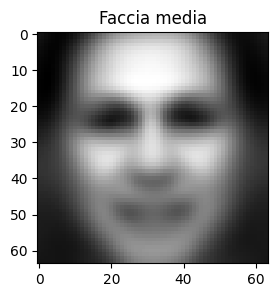

In [16]:
faceMean = np.zeros((dim,dim), dtype=np.float32)
faceNumber = 0
listOfArray = []
faceLabel = []

for key in tagFoto:
    for im in tagFoto[key]:
        vj = violajones(im)
        faceMean += vj
        flat = vj.flat
        listOfArray.append(flat)
        faceLabel.append(key)
        faceNumber+=1

faceMean /= faceNumber

MatrixFlattenedImages = np.vstack(listOfArray)  

MatrixFlattenedImages = normalize(MatrixFlattenedImages)

np.random.shuffle(MatrixFlattenedImages)

fig, axes = plt.subplots(1,1,sharex=True,sharey=True,figsize=(3,3))
axes.imshow(faceMean, cmap="gray")
axes.set_title("Faccia media")
plt.show()

Qui viene svolta e salvata la PCA delle foto raccolte nel set di training, questo passaggio viene svolto solo quando vi è una modifica del set di training, quindi possiamo serializzare il risultato in un file pickle e caricarla quando necessario.

La PCA ci restituisce di fatto i dati di cui abbiamo bisogno, tra cui le autofacce, faccia media ed in generale il nostro spazio dei volti.



Il codice viene lasciato commentato per evitare di utilizzare più tempo del necessario, ma sarà comunque essenziale lanciarlo almeno la prima volta che viene utilizzato il notebook

In [17]:
pca = PCA().fit(MatrixFlattenedImages)


with open('pca.pkl', 'wb') as pickle_file:
    pickle.dump(pca, pickle_file)

Una volta ricaricato la PCA serializzata, calcoliamo i pesi per lo spazio di facce generico.

In [18]:
with open('pca.pkl', 'rb') as pickle_file:
    pca = pickle.load(pickle_file)

eigenfaces = pca.components_
weights = eigenfaces @ (MatrixFlattenedImages - pca.mean_).T


Qui viene caricata la galleria dei volti del nostro "mondo chiuso", ovvero lo spazio delle facce che il software può riconoscere attraverso il classificatore KNN, applichiamo quindi le stesse operazioni fatte in precedenza per il training set

In [19]:
root = "galleria"
listDirGalleria = os.listdir(root)
tagFotoGalleria = {}

for dir in listDirGalleria:
    imgs =  glob.glob(f"{root}/{dir}/*.jpg")
    tagFotoGalleria[dir] = imgs
galleria = []
labelGalleria = []
listOfGalleria = []

for key in tagFotoGalleria:
    for im in tagFotoGalleria[key]:
        img = cv2.imread(im,0)
        img = img.reshape(1,-1)
        listOfGalleria.append(img)
        labelGalleria.append(key)
        
MatrixFlattenedGallery = np.vstack(listOfGalleria)
MatrixFlattenedGallery = normalize(MatrixFlattenedGallery)
indexFotoGalleria = list(np.arange(0,len(labelGalleria)))

#Il metodo shuffle di sklearn permette di modificare l'ordine di diversi array nello stesso modo, cosi da mantenere la consistenza dei dati
#il parametro random_state invece indica il seme per l'ordimento pseudocasuale
MatrixFlattenedGallery,labelGalleria = shuffle(MatrixFlattenedGallery,labelGalleria, random_state=42)


pcaGallery = PCA().fit(MatrixFlattenedGallery)
galleryComponent = pcaGallery.components_

varianzaCumulataGalleria = pcaGallery.explained_variance_ratio_.cumsum()

index95Galleria = list(map(lambda i: i> 0.95, varianzaCumulataGalleria)).index(True)

index9999Galleria = list(map(lambda i: i> 0.9999, varianzaCumulataGalleria)).index(True)

print(f"numero di componenti per avere il 95%  \t{index95Galleria} \nnumero di componenti per avere il 99,99% {index9999Galleria} ")

galleria95perc = pcaGallery.components_[:index95Galleria]
galleria9999perc = pcaGallery.components_[:index9999Galleria]

indexFotoGalleria95 = list(np.arange(0,len(galleria95perc)))
indexFotoGalleria9999 = list(np.arange(0,len(galleria9999perc)))



numero di componenti per avere il 95%  	78 
numero di componenti per avere il 99,99% 561 


Tra i requisiti dell'assignment troviamo la ricerca del miglior compromesso per il classificatore tra un numero di vicini pari ad 1, 3 e 5, quindi creiamo un oggetto KNeighborsClassifier con il parametro relativo impostato con i tre valori e poi ne facciamo il training con la funzione fit.

Il trainign prevede i dati da trovare e le label in quanto è un tipo di training supervisionato, per poter ritrovare le corrispondenze tra label e foto è stato passato un array di lunghezza pari a quello delle label in modo da poterlo passare dopo come indice per farsi restituire nome ed immagine.

La funzione KNeighborsClassifier, tra le altre cose, accetta tra i parametri di ingresso la scelta della metrica per decidere le distanze e come distribuire il carico attraverso dei jobs che possono essere parallelizzati, nel caso specifico di questo progetto utilizziamo i parametri di default in quanto il set è piccolo e non è necessario parallelizzare.

In [28]:
knn1_95 = KNeighborsClassifier(n_neighbors=1)
knn1_95.fit(galleria95perc,indexFotoGalleria95)
knn3_95 = KNeighborsClassifier(n_neighbors=3)
knn3_95.fit(galleria95perc,indexFotoGalleria95)
knn5_95 = KNeighborsClassifier(n_neighbors=5)
knn5_95.fit(galleria95perc,indexFotoGalleria95)

knn1_9999 = KNeighborsClassifier(n_neighbors=1)
knn1_9999.fit(galleria9999perc,indexFotoGalleria9999)
knn3_9999 = KNeighborsClassifier(n_neighbors=3)
knn3_9999.fit(galleria9999perc,indexFotoGalleria9999)
knn5_9999 = KNeighborsClassifier(n_neighbors=5)
knn5_9999.fit(galleria9999perc,indexFotoGalleria9999)

KNeighborsClassifier()

La funzione knnPredict prende in input un vettore di features di lunghezza 4096 (lunghezza del set di training) e le passa ai tre classificatori e ritorna la previsione

In [29]:
def knnPredict95(query):
    predict1 = knn1_95.predict(query)
    predict3 = knn3_95.predict(query)    
    predict5 = knn5_95.predict(query)

    return predict1, predict3, predict5

def knnPredict9999(query):
    predict1 = knn1_9999.predict(query)
    predict3 = knn3_9999.predict(query)    
    predict5 = knn5_9999.predict(query)

    return predict1, predict3, predict5

Applichiamo quindi ad un immagine di test la previsione per verificare che la label sia corretta

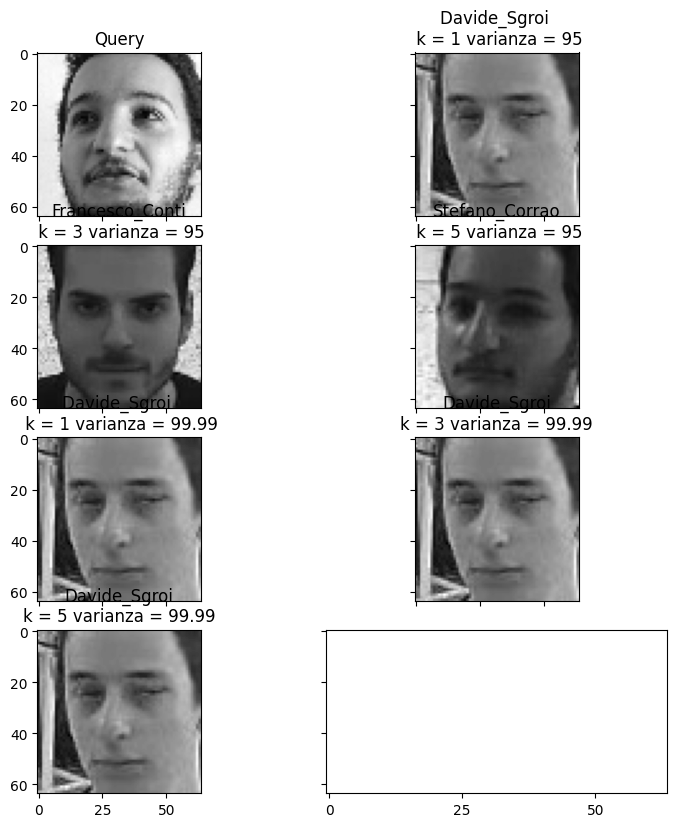

In [30]:
vj = violajones("test/0.jpg") 
vj = normalize(vj)   
query = vj.reshape(1,-1)

query_weight = eigenfaces @ (query - pca.mean_).T
query_weight = query_weight.reshape(1,-1)

knn95 = knnPredict95(query_weight)

knn9999 = knnPredict9999(query_weight)


fig, axes = plt.subplots(4,2,sharex=True,sharey=True,figsize=(8,8))
fig.tight_layout()
axes[0][0].imshow(query.reshape(dim,dim), cmap="gray")
axes[0][0].set_title(f"Query")

axes[0][1].imshow(MatrixFlattenedGallery[int(knn95[0])].reshape(dim,dim), cmap="gray")
axes[0][1].set_title(f"{labelGalleria[int(knn95[0])]} \n k = 1 varianza = 95")

axes[1][0].imshow(MatrixFlattenedGallery[int(knn95[1])].reshape(dim,dim), cmap="gray")
axes[1][0].set_title(f"\n{labelGalleria[int(knn95[1])]}\n k = 3 varianza = 95")

axes[1][1].imshow(MatrixFlattenedGallery[int(knn95[2])].reshape(dim,dim), cmap="gray")
axes[1][1].set_title(f"\n{labelGalleria[int(knn95[2])]}\n k = 5 varianza = 95")

axes[2][0].imshow(MatrixFlattenedGallery[int(knn9999[0])].reshape(dim,dim), cmap="gray")
axes[2][0].set_title(f"{labelGalleria[int(knn9999[0])]} \n k = 1 varianza = 99.99")

axes[2][1].imshow(MatrixFlattenedGallery[int(knn9999[1])].reshape(dim,dim), cmap="gray")
axes[2][1].set_title(f"\n{labelGalleria[int(knn9999[1])]}\nk = 3 varianza = 99.99")

axes[3][0].imshow(MatrixFlattenedGallery[int(knn9999[2])].reshape(dim,dim), cmap="gray")
axes[3][0].set_title(f"\n{labelGalleria[int(knn9999[2])]}\nk = 5 varianza = 99.99")

plt.show()


La funzione violajonesMultiple invece è stata impostata per ritornare tutte le facce e le posizioni in un array in quanto sarà necessario per impostare i quadrati ed i nomi sui volti nel video.


| k\varianza(%) | 95  | 99.99 |
| --- | --- | --- |
| 1   | 16/80 (20%) | 11/80(13.75%) |
| 3   | 21/80 (26.25%) | 11/80(13.75%) |
| 5   | 16/80(20%) | 12/80(15%) |

Nella tabella vengono proposti il numero di volti riconosciuti nel test set, questi valori ci aiutano a trovare il miglior classificatore per il riconoscimento del video finale. Dai dati ottenuti si nota una maggiore precisione nel caso in cui si usino tanti vicini con un set ridotto di features, mentre aumentando il set la precisione diminuisce. Questi risultati possono essere influenzati dal numero di campioni e di label presenti (4 label per circa 800 campioni) che portano ad avere un accumulo di caratteristiche simili che traggono in errore il classificatore.

Una possibile ottimizzazione futura potrebbe essere quella della selezione dei campioni rimuovendo le immagini poco chiare o migliorarne la qualità tramite metodi di preprocessing.

In [65]:
def violajonesMultiple(img):
    faceROI = np.zeros((dim,dim), dtype=np.float32)
    faces = face_cascade.detectMultiScale(img)
    listOfFaceROI = []
    pos =[]
    for (x, y, w, h) in faces:
        faceROI = img[y:y + h, x:x + w]
        faceROI = normalize(cv2.resize(faceROI,(dim,dim), interpolation=cv2.INTER_LINEAR))
        listOfFaceROI.append(faceROI)
        pos.append([(x, y), (x+w, y+h), (255, 0, 255), 4])
    return listOfFaceROI, pos

def findCorrespondence(frame):
    font = cv2.FONT_HERSHEY_SIMPLEX
    faceNumber = 0
    frameFaceLabel = []
    vjMul, pos = violajonesMultiple(frame)
    for vj in vjMul:
        vj = normalize(vj)
        query = vj.reshape(1,-1)
        query_weight = eigenfaces @ (query - pca.mean_).T
        best_match = knn3_95.predict(query_weight.reshape(1,-1))
        frameFaceLabel.append(str(best_match[0]))
    for p in pos:
        px,py = p[0]
        frame = cv2.putText(frame, labelGalleria[int(frameFaceLabel[faceNumber])], (px-5,py-5) ,font, 1,(255,255,255),2 )
        faceNumber+=1
        frame = cv2.rectangle(frame, p[0],p[1],p[2],p[3])
    return frame




A questo punto parte il processo di raccolta dei frame e di riconoscimento dei volti, vengono prima messi tutti i frame in un array, a quel punto per ogni frame nell'array vengono riconosciuti i volti.


Attenzione: è richiesta molta memoria durante questa fase del notebook, è consigliabile chiudere le altre finestre per non perdere il lavoro in caso si dovesse verificare qualche evento inaspettato.

In [66]:
video = cv2.VideoCapture("Video finale senza riconoscimento.mp4")
frames = []
if (video.isOpened()== False):
    print("Error opening video file")
while(video.isOpened()):
  ret, frame = video.read()
  if ret == True:
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
  else:
      break

riconosciuti=[]
for f in frames:
    riconosciuti.append(findCorrespondence(f))

A questo punto vengono invece ricostruiti i frame in un video da 15 fps, valore trovato dopo dei test per avere un buon compromesso tra la durata del video e la leggibilità 

In [63]:
height, width = riconosciuti[0].shape
size = (width,height)

fourcc = -1 

out15 = cv2.VideoWriter('project_video_finale.mp4',fourcc, 15, size)

for i in riconosciuti:
    out15.write(i)
out15.release()


Qui è possibile avviare una sessione live di riconoscimento facciale tramite la webcam del pc

Per l'implementazione non è stato necessario implementare tecniche di multiprocessing in quanto la dimensione delle immagini non satura le potenzialità di un singolo core, se fossero state implementate tecniche di preprocessing più impegnative della normalizzazione discussa in precedenza (come ad esempio allineamento dei volti o uniformazione dell'illuminazione) il multiprocessing avrebbe aiutato la fluidità della visualizzazione.

Si noti che un implementazione multithread non sarebbe stata in grado di fornire un aumento delle prestazioni in quanto un thread vive nello stesso spazio del processo principale.

In [31]:
camera = cv2.VideoCapture(0)
if not camera.isOpened:
    print('--(!)Error opening video capture')
    exit(0)

font = cv2.FONT_HERSHEY_SIMPLEX

while True:
    ret, frame = camera.read()
    if frame is None:
        print('--(!) No captured frame -- Break!')
        break
    
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(frame_gray)
    for (x, y, w, h) in faces:
        center = (x + w // 2, y + h // 2)   
        faceROI = frame_gray[y:y + h, x:x + w]
        faceROI = normalize(cv2.resize(faceROI,(dim,dim), interpolation=cv2.INTER_LINEAR))

        query = faceROI.reshape(1,-1)
        query_weight = eigenfaces @ (query - pca.mean_).T
        best_match = knn5_95.predict(query_weight.reshape(1,-1))
        frame = cv2.putText(frame, labelGalleria[int(best_match[0])], (x-5,y-5) ,font, 1,(255,255,255),2 )

        frame = cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 255), 4)
    cv2.imshow('Capture - Face detection', frame)
    if cv2.waitKey(10) == 27:
        cv2.destroyAllWindows()
        break

Note aggiuntive:

Durante lo svolgimento del compito è stato tentato l'allineamento dei volti attraverso l'allineamento degli occhi.
Questo metodo è ampliamente utilizzato in combinazione con la regolazione della luce nelle immagini per renderle indipendenti da ombre o possibili flare della lente.
Mentre veniva implementato l'allineamento è sorta una complicazione riguardo l'ordine delle operazioni: Se si fossero allineati prima gli occhi avremmo avuto n frame angolati diversamente (con n numero volti) e si sarebbe dovuto tenere traccia dei volti già rilevati, al contrario se si fossero prima riconosciute le facce si sarebbero perse quelle che avevano un allineamento oltre il limite imposto dalle matrici prsenti in *haarcascade_frontalface_alt* pertanto si è deciso di lasciare l'implementazione di queste tecniche a future revisioni per limitazioni di tempo.

Altre implementazioni del metodo di Viola Jones prevedono metodi ibridi che usano detector come HOG (Histogram of Oriented Gradients) che si occupa principalmente delle forme degli oggetti, altre invece utilizzano tecniche più avanzate come quella del deep learning, che in combinazione con metodi più semplici permettono di ottenere risultati molto migliori ed accurati, oltre a permettere l'elaborazione di grandi quantità di dati, alcune di queste implementazioni sono utilizzate per gestire il traffico automobilistico o per la classificazione dei prodotti in catena di montaggio.

Altri limiti di questo sistema di riconoscimento sono dati dal set di immagini di training che ha una prevalenza di volti maschili andando a creare un bias nelle autofacce e la qualità delle immagini passate al classificatore che hanno inficiato in negativo le performance, come descritto in precedenza la selezione delle foto sarebbe un ottimo punto di partenza per migliorare l'efficenza e la precisione.



La versione più recente di questo progetto è disponibile su [github](https://github.com/Montenigri/VisioneArtificiale)
